In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cmcrameri import cm
import babet as bb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import metpy.calc as mpcalc 
from metpy.units import units

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
# inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
# Import forecast data 
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/sfc/pf'
exp = {}
for experiment in experiments:
    exp[experiment] = xr.open_mfdataset(os.path.join(base_dir.format(experiment), '*.nc'), preprocess=bb.Data.preproc_ds)

In [3]:
# Import ERA5 data
era5_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5/EU025/sfc/'
era5 = xr.open_mfdataset(os.path.join(era5_dir, '*.nc'))
era5 = era5.sel(time=slice('2023-10-17 00', '2023-10-23 00'))

In [24]:
# Define area, same as for analogues
lat_min = 40
lat_max = 65
lon_min = -20
lon_max = 20

In [70]:
def get_area_weights(lat, lon):
    '''
    Get the area weights based on a lat/lon grid

    Inputs
    ------
    lat : xr.DataArray
        Latitude array
    
    Returns
    -------
    xr.DataArray
        Area weights
    '''

    lat_rad = np.radians(lat).values  # Convert latitude to radians
    weights = (np.cos(lat_rad))[np.newaxis, :] # Compute weights as cos(latitude)
    # llat, llon = np.meshgrid(lat, lon) # Create meshgrid
    weights_mesh = np.tile(weights, (len(lon), 1)).T # Tile weights to match meshgrid
    
    return xr.DataArray(weights_mesh, coords=[lat, lon], dims=["latitude", "longitude"])


In [72]:
# test =exp['pi'].sel(time=slice('2023-10-20 00', '2023-10-21 00'), latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max), inidate='2023-10-17', number=1).mean(dim='time').msl
# get_area_weights(test.latitude, test.longitude).shape

In [116]:
def euclidean_distance(field,event):
    '''
    Calculate the euclidean distance between a field and an event.

    Inputs
    -------
      field = single cube of psi.
      event = cube of single day of event to match.
      BOTH MUST HAVE SAME DIMENSIONS FOR LAT/LON

    Outputs
    -------
        D = list of euclidean distances between field and event.
    
    Written by Vikki Thompson and Shirin Ermis.
    '''
    D = []  # to be list of all euclidean distances
    
    # if not event.coord('latitude').has_bounds():
    #     event.coord('latitude').guess_bounds()
    # if not event.coord('longitude').has_bounds():
    #     event.coord('longitude').guess_bounds()
    
    weights = get_area_weights(event.latitude, event.longitude)
    event = event * weights
    members, lats, lons = np.shape(field.data) # get dimensions of field
    field = field * np.array([weights] * members) 
    
    XA = event.data.reshape(lats * lons, 1)
    XB = field.data.reshape(members,lats * lons, 1)
    
    for Xb in XB:
        D.append(np.sqrt(np.sum(np.square(XA - Xb))))
    
    return D

In [126]:
era5_20 = era5.sel(time=slice('2023-10-20 00', '2023-10-21 00'), latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max)).mean(dim='time').msl
exp20 = {exp_key: exp[exp_key].sel(time=slice('2023-10-20 00', '2023-10-21 00'), latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max), inidate=slice('2023-10-15', '2023-10-17')).mean(dim='time').msl for exp_key in exp.keys()}
distance = {}
inidates = ['2023-10-15', '2023-10-17']

for inidate in inidates:
    distance[inidate] = {}
    for experiment in experiments:
            ensemble = exp20[experiment].sel(inidate=inidate)
            distance[inidate][experiment] = euclidean_distance(ensemble, era5_20)

In [136]:
plot_data = []
    
for outer_key, inner_dict in distance.items():
    for inner_key, dask_array in inner_dict.items():
        values = dask.compute(*dask_array)  # Convert dask array to NumPy
        for v in values:
                plot_data.append({'inidate': outer_key, 'experiment': inner_key, 'euclidean_distance': v})
    
df = pd.DataFrame(plot_data)

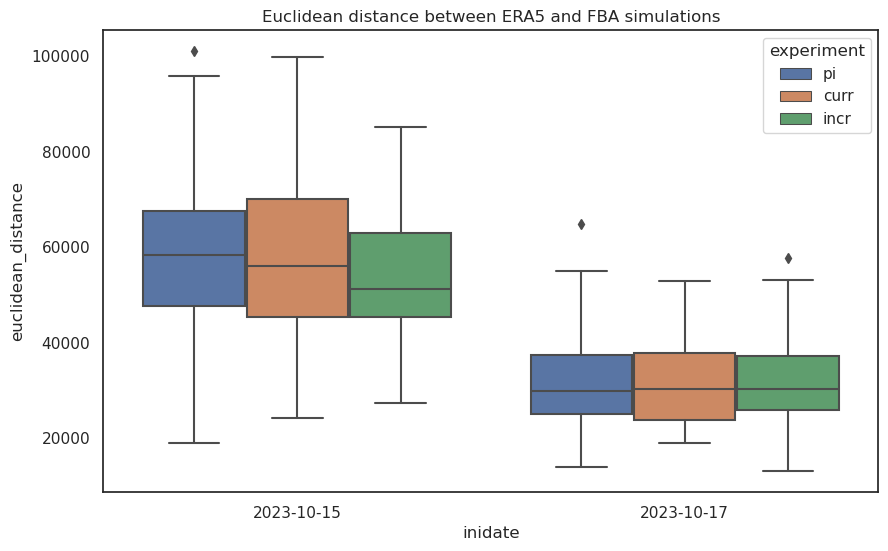

In [138]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='inidate', y='euclidean_distance', hue='experiment', data=df)
plt.title("Euclidean distance between ERA5 and FBA simulations")
plt.legend(title='experiment')
plt.show()